In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
import copy
import gc
from pathlib import Path
from tqdm.notebook import tqdm
import warnings

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pytorch_lightning as pl
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup,
    get_cosine_schedule_with_warmup,
)

import optim
import loss
from utils import visualize, radar2precipitation, seed_everything

<IPython.core.display.Javascript object>

In [4]:
warnings.simplefilter("ignore")

<IPython.core.display.Javascript object>

# 🔥 Baseline ⚡️

In [14]:
args = dict(
    seed=42,
    dams=(6071, 6304, 7026, 7629, 7767, 8944, 11107),
    train_folds_csv=Path("../input/train_folds.csv"),
    train_data_path=Path("../input/train"),
    test_data_path=Path("../input/test"),
    model_dir=Path("../models"),
    output_dir=Path("../output"),
    rng=255.0,
    num_workers=4,
    gpus=1,
    lr=1e-3,
    max_epochs=50,
    batch_size=128,
    precision=16,
    optimizer="adamw",
    scheduler="cosine",
    warmup_epochs=1,
    accumulate_grad_batches=1,
    gradient_clip_val=5.0,
)

args["trn_tfms"] = A.Compose(
    [
        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, p=1),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        # D_4 transformations
        A.VerticalFlip(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Transpose(p=0.5),
        A.RandomRotate90(p=0.5),
        ToTensorV2(always_apply=True, p=1),
    ]
)

args["val_tfms"] = A.Compose(
    [
        A.PadIfNeeded(min_height=128, min_width=128, always_apply=True, p=1),
        ToTensorV2(always_apply=True, p=1),
    ]
)

<IPython.core.display.Javascript object>

## Dataset

In [6]:
class NowcastingDataset(Dataset):
    def __init__(self, paths, tfms=None, test=False):
        self.paths = paths
        if tfms is not None:
            self.tfms = tfms
        else:
            self.tfms = A.Compose(
                [
                    A.PadIfNeeded(
                        min_height=128, min_width=128, always_apply=True, p=1
                    ),
                    ToTensorV2(always_apply=True, p=1),
                ]
            )
        self.test = test

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = np.load(path)

        augmented = self.tfms(image=data)
        data = augmented["image"]

        x = data[:4, :, :]
        x = x / args["rng"]
        if self.test:
            return x
        else:
            y = data[4, :, :]
            y = y / args["rng"]
            y = y.unsqueeze(0)
            return x, y

<IPython.core.display.Javascript object>

In [7]:
class NowcastingDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df=None,
        val_df=None,
        batch_size=args["batch_size"],
        num_workers=args["num_workers"],
        test=False,
    ):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.test = test

    def setup(self, stage="train"):
        if stage == "train":
            train_paths = [
                args["train_data_path"] / fn for fn in self.train_df.filename.values
            ]
            val_paths = [
                args["train_data_path"] / fn for fn in self.val_df.filename.values
            ]
            self.train_dataset = NowcastingDataset(train_paths)
            self.val_dataset = NowcastingDataset(val_paths)
        else:
            test_paths = list(sorted(args["test_data_path"].glob("*.npy")))
            self.test_dataset = NowcastingDataset(test_paths, test=True)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            sampler=RandomSampler(self.train_dataset),
            pin_memory=True,
            num_workers=self.num_workers,
            drop_last=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=2 * self.batch_size,
            sampler=SequentialSampler(self.val_dataset),
            pin_memory=True,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=2 * self.batch_size,
            sampler=SequentialSampler(self.test_dataset),
            pin_memory=True,
            num_workers=self.num_workers,
        )

<IPython.core.display.Javascript object>

In [8]:
# df = pd.read_csv(args["train_folds_csv"])

# fold = 0
# train_df = df[df["fold"] != fold]
# val_df = df[df["fold"] == fold]

# datamodule = NowcastingDataModule(train_df, val_df)
# datamodule.setup()

# for batch in datamodule.train_dataloader():
#     xs, ys = batch
#     idx = np.random.randint(len(xs))
#     x, y = xs[idx], ys[idx]
#     print(x.shape, y.shape)
#     x = x.detach().cpu().numpy().transpose(1, 2, 0)
#     y = y.unsqueeze(-1)
#     y = y.detach().cpu().numpy()
#     visualize(x, y)
#     break

<IPython.core.display.Javascript object>

In [ ]:
def visualize_augmentations(dataset, idx=0):
    dataset = copy.deepcopy(dataset)
    dataset.tfms = A.Compose([t for t in dataset.tfms if not isinstance(t, [A.Normalize, ToTensorV2])])
    for i in range(samples):
        x, y = dataset[idx]
        visualize(x, y)

## Model

### Layers

In [9]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.net(x)


class Encoder(nn.Module):
    def __init__(self, chs=[4, 64, 128]):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.blocks = nn.ModuleList(
            [Block(chs[i], chs[i + 1]) for i in range(len(chs) - 1)]
        )
        self.conv = nn.Conv2d(128, 512, kernel_size=3, padding=1)

    def forward(self, x):
        ftrs = []
        for block in self.blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        x = self.conv(x)
        ftrs.append(x)
        return ftrs


class Decoder(nn.Module):
    def __init__(self, chs=[512, 128, 64], bilinear=False):
        super().__init__()
        if bilinear:
            self.upsamples = nn.ModuleList(
                [
                    nn.Upsample(scale_factor=2, mode="nearest")
                    for i in range(len(chs) - 1)
                ]
            )
        else:
            self.upsamples = nn.ModuleList(
                [
                    nn.ConvTranspose2d(chs[i], chs[i + 1], kernel_size=2, stride=2)
                    for i in range(len(chs) - 1)
                ]
            )
        self.blocks = nn.ModuleList(
            [Block(2 * chs[i + 1], chs[i + 1]) for i in range(len(chs) - 1)]
        )

    def forward(self, x, ftrs):
        for i, ftr in enumerate(ftrs):
            x = self.upsamples[i](x)
            x = torch.cat([ftr, x], dim=1)
            x = self.blocks[i](x)
        return x

<IPython.core.display.Javascript object>

### Model

In [10]:
class Baseline(pl.LightningModule):
    def __init__(
        self,
        lr=args["lr"],
        enc_chs=[4, 64, 128],
        dec_chs=[512, 128, 64],
        num_train_steps=None,
        bilinear=False,
    ):
        super().__init__()
        self.lr = lr
        self.num_train_steps = num_train_steps
        self.criterion = nn.L1Loss()
        self.encoder = Encoder(enc_chs)
        self.decoder = Decoder(dec_chs, bilinear=bilinear)
        self.out = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
            #             nn.ReLU(inplace=True),
        )

    def forward(self, x):
        ftrs = self.encoder(x)
        ftrs = ftrs[::-1]
        x = self.decoder(ftrs[0], ftrs[1:])
        out = self.out(x)
        return out

    def shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss, y, y_hat

    def training_step(self, batch, batch_idx):
        loss, y, y_hat = self.shared_step(batch, batch_idx)
        self.log("train_loss", loss)

        for i, param_group in enumerate(self.optimizer.param_groups):
            self.log(f"lr/lr{i}", param_group["lr"])

        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        loss, y, y_hat = self.shared_step(batch, batch_idx)

        return {"loss": loss, "y": y.detach(), "y_hat": y_hat.detach()}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        self.log("val_loss", avg_loss)

        y = torch.cat([x["y"] for x in outputs])
        y_hat = torch.cat([x["y_hat"] for x in outputs])

        crop = T.CenterCrop(120)
        y = crop(y)
        y_hat = crop(y_hat)

        batch_size = len(y)

        y = y.reshape(batch_size, -1)
        y = y.detach().cpu().numpy()
        y *= args["rng"]
        y_hat = y_hat.reshape(batch_size, -1)
        y_hat = y_hat.detach().cpu().numpy()
        y_hat *= args["rng"]

        y = y[:, args["dams"]]
        y_hat = y_hat[:, args["dams"]]

        y_true = radar2precipitation(y)
        y_true = np.nan_to_num(y_true)
        y_true = np.where(y_true >= 0.1, 1.0, 0.0)
        y_pred = radar2precipitation(y_hat)
        y_pred = np.nan_to_num(y_pred)
        y_pred = np.where(y_pred >= 0.1, 1.0, 0.0)

        y_true = y_true.ravel()
        y_pred = y_pred.ravel()

        tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
        csi = tp / (tp + tn + tp)
        self.log("csi", csi)

        y = y.ravel()
        y_hat = y_hat.ravel()

        mae = metrics.mean_absolute_error(y, y_hat, sample_weight=y_true)
        self.log("mae", mae)

        comp_metric = mae / (csi + 1e-12)
        self.log("comp_metric", comp_metric)

        print(
            f"Epoch {self.current_epoch} | MAE/CSI: {comp_metric} | MAE: {mae} | CSI: {csi} | Loss: {avg_loss}"
        )

    def configure_optimizers(self):
        if args["optimizer"] == "adam":
            self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif args["optimizer"] == "adamw":
            self.optimizer = AdamW(self.parameters(), lr=self.lr)
        elif args["optimizer"] == "radam":
            self.optimizer = optim.RAdam(self.parameters(), lr=self.lr)
        elif args["optimizer"] == "ranger":
            self.optimizer = optim.RAdam(self.parameters(), lr=self.lr)
            self.optimizer = optim.Lookahead(self.optimizer)

        if args["scheduler"] == "cosine":
            self.scheduler = get_cosine_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=self.num_train_steps * args["warmup_epochs"],
                num_training_steps=self.num_train_steps * args["max_epochs"],
            )
            return [self.optimizer], [{"scheduler": self.scheduler, "interval": "step"}]
        elif args["scheduler"] == "step":
            self.scheduler = torch.optim.lr_scheduler.StepLR(
                self.optimizer, step_size=10, gamma=0.5
            )
            return [self.optimizer], [
                {"scheduler": self.scheduler, "interval": "epoch"}
            ]
        elif args["scheduler"] == "plateau":
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer, mode="min", factor=0.1, patience=3, verbose=True
            )
            return [self.optimizer], [
                {
                    "scheduler": self.scheduler,
                    "interval": "epoch",
                    "reduce_on_plateau": True,
                    "monitor": "comp_metric",
                }
            ]
        else:
            self.scheduler = None
            return [self.optimizer]

<IPython.core.display.Javascript object>

## Train

In [11]:
seed_everything(args["seed"])
pl.seed_everything(args["seed"])

42

<IPython.core.display.Javascript object>

In [12]:
df = pd.read_csv(args["train_folds_csv"])

<IPython.core.display.Javascript object>

In [13]:
def train_fold(df, fold, lr_find=False, bilinear=False):
    train_df = df[df.fold != fold]
    val_df = df[df.fold == fold]

    datamodule = NowcastingDataModule(train_df, val_df)
    datamodule.setup()

    num_train_steps = np.ceil(
        len(train_df) // args["batch_size"] / args["accumulate_grad_batches"]
    )
    model = Baseline(num_train_steps=num_train_steps, bilinear=bilinear)

    trainer = pl.Trainer(
        gpus=args["gpus"],
        max_epochs=args["max_epochs"],
        precision=args["precision"],
        progress_bar_refresh_rate=50,
        benchmark=True,
    )

    if lr_find:
        lr_finder = trainer.tuner.lr_find(model, datamodule=datamodule)
        fig = lr_finder.plot(suggest=True)
        fig.show()
        return

    print(f"Training fold {fold}...")
    trainer.fit(model, datamodule)

    checkpoint = (
        args["model_dir"]
        / f"{model.__name__}_fold{fold}_bs{args['batch_size']}_epochs{args['max_epochs']}_lr{args['lr']}_{args['optimizer']}_{args['scheduler']}.ckpt"
    )
    trainer.save_checkpoint(checkpoint)
    print("Model saved at", checkpoint)

    del model, trainer, datamodule
    gc.collect()
    torch.cuda.empty_cache()

<IPython.core.display.Javascript object>

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 666 K 
2 | decoder   | Decoder    | 664 K 
3 | out       | Sequential | 577   


Epoch 0 | MAE/CSI: 52.923903508666086 | MAE: 26.461951754385964 | CSI: 0.5 | Loss: 0.46036389470100403


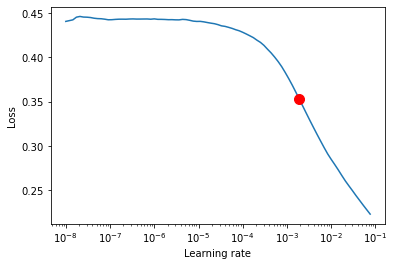

<IPython.core.display.Javascript object>

In [14]:
# AdamW bs128
fold = 2
train_fold(df, fold, lr_find=True)

In [ ]:
# AdamW bs128 lr 1e-3
args["lr"] = 1e-3
for fold in range(5):
    train_fold(df, fold, bilinear=False)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Training fold 0...



  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 666 K 
2 | decoder   | Decoder    | 664 K 
3 | out       | Sequential | 577   


Epoch 0 | MAE/CSI: 53.56019332150975 | MAE: 26.780096660808436 | CSI: 0.5 | Loss: 0.459513783454895


Epoch 0 | MAE/CSI: 170.78198657664493 | MAE: 19.724538597648753 | CSI: 0.1154954277840411 | Loss: 0.03388248383998871


Epoch 1 | MAE/CSI: 168.09719137592097 | MAE: 19.445352762116123 | CSI: 0.11567922463654838 | Loss: 0.01738419197499752


Epoch 2 | MAE/CSI: 156.6301722789477 | MAE: 18.345966234554943 | CSI: 0.11712919654921526 | Loss: 0.014978960156440735


Epoch 3 | MAE/CSI: 153.16585072035386 | MAE: 17.831609552130818 | CSI: 0.11642026906202566 | Loss: 0.013435683213174343


Epoch 4 | MAE/CSI: 153.70531443705724 | MAE: 17.874716459482965 | CSI: 0.11629211732069944 | Loss: 0.013055997900664806


Epoch 5 | MAE/CSI: 145.8983442662249 | MAE: 17.088025319397794 | CSI: 0.11712281866661134 | Loss: 0.012393633835017681


Epoch 6 | MAE/CSI: 143.4202452247388 | MAE: 16.87795204792279 | CSI: 0.11768179604861018 | Loss: 0.012272193096578121


Epoch 7 | MAE/CSI: 146.4282524239353 | MAE: 17.065826203388355 | CSI: 0.11654735968461459 | Loss: 0.012017824687063694


Epoch 8 | MAE/CSI: 129.85278342938832 | MAE: 15.581797679234832 | CSI: 0.11999586968867779 | Loss: 0.011971008963882923


Epoch 9 | MAE/CSI: 134.05535043597598 | MAE: 16.00679508846232 | CSI: 0.11940437316579176 | Loss: 0.011959600262343884


Epoch 10 | MAE/CSI: 140.76686692498777 | MAE: 16.535682479067635 | CSI: 0.11746856941654067 | Loss: 0.011665204539895058


Epoch 11 | MAE/CSI: 130.23951067816992 | MAE: 15.606691854700246 | CSI: 0.11983070093940332 | Loss: 0.011709283106029034


Epoch 12 | MAE/CSI: 132.36199857715235 | MAE: 15.761254895113252 | CSI: 0.11907688811297171 | Loss: 0.011555482633411884


Epoch 13 | MAE/CSI: 124.93553981566286 | MAE: 15.046651819269396 | CSI: 0.1204353208170002 | Loss: 0.01154946256428957


Epoch 14 | MAE/CSI: 128.63004962626593 | MAE: 15.362794990173457 | CSI: 0.11943395057905493 | Loss: 0.011369111016392708


Epoch 15 | MAE/CSI: 129.77422030111205 | MAE: 15.441686274845175 | CSI: 0.11898885802501007 | Loss: 0.011360766366124153


Epoch 16 | MAE/CSI: 127.89916308801553 | MAE: 15.234987177638311 | CSI: 0.11911717645115669 | Loss: 0.011271754279732704


Epoch 17 | MAE/CSI: 135.44538979312 | MAE: 15.977836448976952 | CSI: 0.1179651553533578 | Loss: 0.011291386559605598


Epoch 18 | MAE/CSI: 131.01412553221857 | MAE: 15.535309247329916 | CSI: 0.11857736090738177 | Loss: 0.011206930503249168


Epoch 19 | MAE/CSI: 128.3795142809382 | MAE: 15.316376204536423 | CSI: 0.11930545375713593 | Loss: 0.01129260752350092


Epoch 20 | MAE/CSI: 129.53717930582368 | MAE: 15.393137785459434 | CSI: 0.11883181236321592 | Loss: 0.011146247386932373


Epoch 21 | MAE/CSI: 125.01754290701933 | MAE: 14.967451823814816 | CSI: 0.11972281230020418 | Loss: 0.011126581579446793


Epoch 22 | MAE/CSI: 129.77412030499616 | MAE: 15.383207968860122 | CSI: 0.11853833362596958 | Loss: 0.011081535369157791


Epoch 23 | MAE/CSI: 129.59780063960534 | MAE: 15.416142515156869 | CSI: 0.11895373562625157 | Loss: 0.011135153472423553


Epoch 24 | MAE/CSI: 126.79543782102087 | MAE: 15.121503837131494 | CSI: 0.11925905298224987 | Loss: 0.011023331433534622


Epoch 25 | MAE/CSI: 122.12513950524966 | MAE: 14.662264822229544 | CSI: 0.12005934962700408 | Loss: 0.011004186235368252


Epoch 26 | MAE/CSI: 122.36282637344341 | MAE: 14.725182581222446 | CSI: 0.12034032734876343 | Loss: 0.011074616573750973


In [15]:
# AdamW bs50 lr 5e-4
for fold in range(5):
    train_fold(df, fold)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


Training fold0...



  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 666 K 
2 | decoder   | Decoder    | 664 K 
3 | out       | Sequential | 577   


Epoch 0 | MAE/CSI: 1000000000000.0 | MAE: 1.0 | CSI: 0.0 | Loss: 0.07034780830144882


Epoch 0 | MAE/CSI: 0.9437922424302221 | MAE: 0.11309021113243763 | CSI: 0.1198253238872696 | Loss: 0.01358635164797306


Epoch 1 | MAE/CSI: 1.1144372062329246 | MAE: 0.1309021113243762 | CSI: 0.1174602845195231 | Loss: 0.01243552751839161


Epoch 2 | MAE/CSI: 0.8626368456547189 | MAE: 0.10395393474088292 | CSI: 0.1205071812822022 | Loss: 0.012849031016230583


Epoch 3 | MAE/CSI: 0.9002768018883869 | MAE: 0.10794625719769674 | CSI: 0.11990340856320238 | Loss: 0.011554539203643799


Epoch 4 | MAE/CSI: 1.0671439714543172 | MAE: 0.1256813819577735 | CSI: 0.11777359505243346 | Loss: 0.011750211007893085


Epoch 5 | MAE/CSI: 0.9762669221542187 | MAE: 0.11608445297504799 | CSI: 0.11890646947037925 | Loss: 0.011374273337423801


Epoch 6 | MAE/CSI: 1.268498090098286 | MAE: 0.14641074856046066 | CSI: 0.1154205510454083 | Loss: 0.012063690461218357


Epoch 7 | MAE/CSI: 1.1031854423828713 | MAE: 0.12944337811900192 | CSI: 0.11733601001686725 | Loss: 0.01138242892920971


Epoch 8 | MAE/CSI: 0.8217496448119358 | MAE: 0.09927063339731286 | CSI: 0.12080398698463693 | Loss: 0.011296030133962631


Epoch 9 | MAE/CSI: 1.1088743781210597 | MAE: 0.12998080614203456 | CSI: 0.11721869375426691 | Loss: 0.011095265857875347


Epoch 10 | MAE/CSI: 0.9620862761671343 | MAE: 0.11447216890595009 | CSI: 0.11898326765561493 | Loss: 0.011082764714956284


Epoch 11 | MAE/CSI: 0.8788553600805569 | MAE: 0.105489443378119 | CSI: 0.12003049440077472 | Loss: 0.010911011137068272


Epoch 12 | MAE/CSI: 0.9072385822422571 | MAE: 0.10856046065259117 | CSI: 0.11966032174621005 | Loss: 0.010981745086610317


Epoch 13 | MAE/CSI: 0.9236828223175657 | MAE: 0.11032629558541267 | CSI: 0.11944175307674865 | Loss: 0.010909012518823147


Epoch 14 | MAE/CSI: 0.957795533843998 | MAE: 0.11401151631477927 | CSI: 0.11903533926103191 | Loss: 0.010993537493050098


Epoch 15 | MAE/CSI: 0.8396774933378116 | MAE: 0.10119001919385796 | CSI: 0.12051057697256679 | Loss: 0.01081531960517168


Epoch 16 | MAE/CSI: 0.9688093562689909 | MAE: 0.11516314779270634 | CSI: 0.11887080471151268 | Loss: 0.01078347209841013


Epoch 17 | MAE/CSI: 0.8454214584932136 | MAE: 0.1018042226487524 | CSI: 0.12041830926476794 | Loss: 0.010767708532512188


Epoch 18 | MAE/CSI: 1.0531790624176152 | MAE: 0.12406909788867562 | CSI: 0.11780437184424918 | Loss: 0.011013168841600418


Epoch 19 | MAE/CSI: 0.9021290016177816 | MAE: 0.10802303262955854 | CSI: 0.11974233444988405 | Loss: 0.011004014872014523


Epoch 20 | MAE/CSI: 0.9261467066757963 | MAE: 0.11055662188099807 | CSI: 0.11937268802357572 | Loss: 0.010737544856965542


Epoch 21 | MAE/CSI: 0.738513689685624 | MAE: 0.08998080614203455 | CSI: 0.12184040377044293 | Loss: 0.011556853540241718


Epoch 22 | MAE/CSI: 0.9217058638475384 | MAE: 0.11009596928982726 | CSI: 0.11944805127888043 | Loss: 0.010670513845980167


Epoch 23 | MAE/CSI: 0.8700357218950803 | MAE: 0.10449136276391555 | CSI: 0.12010008340283569 | Loss: 0.010724274441599846


Epoch 24 | MAE/CSI: 0.8609963941380611 | MAE: 0.1034932821497121 | CSI: 0.12020176025528849 | Loss: 0.010626938194036484


Epoch 25 | MAE/CSI: 0.9355479405170692 | MAE: 0.11155470249520154 | CSI: 0.1192399637292886 | Loss: 0.010589144192636013


Epoch 26 | MAE/CSI: 0.8959708216309327 | MAE: 0.1072552783109405 | CSI: 0.11970845000823588 | Loss: 0.010607089847326279


Epoch 27 | MAE/CSI: 0.9535970473260313 | MAE: 0.11347408829174664 | CSI: 0.11899584694497975 | Loss: 0.010617554187774658


Epoch 28 | MAE/CSI: 0.8343800580415958 | MAE: 0.10057581573896353 | CSI: 0.1205395727867638 | Loss: 0.010615648701786995


Epoch 29 | MAE/CSI: 0.9420075384325132 | MAE: 0.11224568138195777 | CSI: 0.11915582073556538 | Loss: 0.010660631582140923


Epoch 30 | MAE/CSI: 0.8873040214686102 | MAE: 0.10633397312859885 | CSI: 0.11983939050756717 | Loss: 0.01054992526769638


Epoch 31 | MAE/CSI: 0.8851448177581197 | MAE: 0.10610364683301343 | CSI: 0.11987151108319863 | Loss: 0.01055346429347992


Epoch 32 | MAE/CSI: 0.9027612589958749 | MAE: 0.10802303262955854 | CSI: 0.11965847177448426 | Loss: 0.010560257360339165


Epoch 33 | MAE/CSI: 0.8119980124723106 | MAE: 0.0981190019193858 | CSI: 0.1208365050301397 | Loss: 0.010586261749267578


Epoch 34 | MAE/CSI: 0.9156443179485217 | MAE: 0.10940499040307101 | CSI: 0.11948415804870009 | Loss: 0.010580405592918396


Epoch 35 | MAE/CSI: 0.9486229827182243 | MAE: 0.11293666026871402 | CSI: 0.1190532617543715 | Loss: 0.010587424039840698


Epoch 36 | MAE/CSI: 0.8343972284753538 | MAE: 0.10057581573896353 | CSI: 0.12053709229344582 | Loss: 0.01055158395320177


Epoch 37 | MAE/CSI: 0.93222359442797 | MAE: 0.11117082533589251 | CSI: 0.1192533915676923 | Loss: 0.010545892640948296


Epoch 38 | MAE/CSI: 0.8951787451674442 | MAE: 0.1071785028790787 | CSI: 0.11972860555143727 | Loss: 0.010513982735574245


Epoch 39 | MAE/CSI: 0.8696352179660404 | MAE: 0.10441458733205375 | CSI: 0.12006710994915289 | Loss: 0.010518943890929222


Epoch 40 | MAE/CSI: 0.9230175593085749 | MAE: 0.11017274472168906 | CSI: 0.11936148300720906 | Loss: 0.010523991659283638


Epoch 41 | MAE/CSI: 0.865406931654537 | MAE: 0.10395393474088292 | CSI: 0.12012144915603129 | Loss: 0.010527591221034527


Epoch 42 | MAE/CSI: 0.9123202405399485 | MAE: 0.109021113243762 | CSI: 0.11949873344728876 | Loss: 0.010516504757106304


Epoch 43 | MAE/CSI: 0.878891236774245 | MAE: 0.1054126679462572 | CSI: 0.11993823983530623 | Loss: 0.010505661368370056


Epoch 44 | MAE/CSI: 0.8987529011976216 | MAE: 0.10756238003838772 | CSI: 0.1196795914585178 | Loss: 0.010510049760341644


Epoch 45 | MAE/CSI: 0.9165924059496204 | MAE: 0.10948176583493283 | CSI: 0.11944433002430284 | Loss: 0.010518706403672695


Epoch 46 | MAE/CSI: 0.8994440072829465 | MAE: 0.10763915547024952 | CSI: 0.11967299197924282 | Loss: 0.010508017614483833


Epoch 47 | MAE/CSI: 0.898789915093023 | MAE: 0.10756238003838772 | CSI: 0.1196746628230207 | Loss: 0.010506379418075085


Epoch 48 | MAE/CSI: 0.9051807552372788 | MAE: 0.10825335892514396 | CSI: 0.11959308491469405 | Loss: 0.010508042760193348


Epoch 49 | MAE/CSI: 0.8824160365458403 | MAE: 0.10579654510556621 | CSI: 0.11989417771555629 | Loss: 0.010502020828425884

Model saved at ../models/baseline_fold0_bs128_epochs50_lr0.0005_adamw.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 666 K 
2 | decoder   | Decoder    | 664 K 
3 | out       | Sequential | 577   


Training fold1...


Epoch 0 | MAE/CSI: 1000000000000.0 | MAE: 1.0 | CSI: 0.0 | Loss: 0.05332362651824951


Epoch 0 | MAE/CSI: 1.4649042747142322 | MAE: 0.1602899718082964 | CSI: 0.10942009971136185 | Loss: 0.013296589255332947


Epoch 1 | MAE/CSI: 1.290671138246638 | MAE: 0.14337494965767217 | CSI: 0.1110855781986066 | Loss: 0.0125888055190444


Epoch 2 | MAE/CSI: 1.2783221086827037 | MAE: 0.14208618606524365 | CSI: 0.11115053482911558 | Loss: 0.011991249397397041


Epoch 3 | MAE/CSI: 0.9015394723596947 | MAE: 0.10398711236407572 | CSI: 0.11534393728873313 | Loss: 0.01250691618770361


Epoch 4 | MAE/CSI: 1.2422832403087438 | MAE: 0.13846153846153847 | CSI: 0.11145730214140571 | Loss: 0.012093799188733101


Epoch 5 | MAE/CSI: 0.7875750740947998 | MAE: 0.0919049536850584 | CSI: 0.11669357843746118 | Loss: 0.01224138680845499


Epoch 6 | MAE/CSI: 1.02749542826656 | MAE: 0.11695529601288764 | CSI: 0.11382561206055195 | Loss: 0.01118035800755024


Epoch 7 | MAE/CSI: 1.195252290179063 | MAE: 0.13370922271445831 | CSI: 0.11186694542390864 | Loss: 0.011427664197981358


Epoch 8 | MAE/CSI: 1.0641914459521074 | MAE: 0.12057994361659283 | CSI: 0.11330662736877063 | Loss: 0.011057481169700623


Epoch 9 | MAE/CSI: 0.9369481790171504 | MAE: 0.10753121224325413 | CSI: 0.11476751292170329 | Loss: 0.010967950336635113


Epoch 10 | MAE/CSI: 0.7484682012246785 | MAE: 0.08763592428513894 | CSI: 0.11708703741988837 | Loss: 0.011205273680388927


Epoch 11 | MAE/CSI: 0.9380351910149244 | MAE: 0.1076923076923077 | CSI: 0.11480625537603764 | Loss: 0.011112474836409092


Epoch 12 | MAE/CSI: 0.9998407717848802 | MAE: 0.11397503020539669 | CSI: 0.11399318113516482 | Loss: 0.010790626518428326


Epoch 13 | MAE/CSI: 0.8450261420411643 | MAE: 0.09794603302456706 | CSI: 0.11590887920595327 | Loss: 0.01095589343458414


Epoch 14 | MAE/CSI: 1.0267842632014805 | MAE: 0.11671365283930729 | CSI: 0.1136691094917749 | Loss: 0.010724475607275963


Epoch 15 | MAE/CSI: 0.9396971828684089 | MAE: 0.10777285541683447 | CSI: 0.1146889204104242 | Loss: 0.010688774287700653


Epoch 16 | MAE/CSI: 0.7939414270633738 | MAE: 0.09246878775674587 | CSI: 0.11646802220407489 | Loss: 0.010742655955255032


Epoch 17 | MAE/CSI: 1.1852240181120506 | MAE: 0.13266210229561015 | CSI: 0.11192998139351164 | Loss: 0.011140896938741207


Epoch 18 | MAE/CSI: 1.0105798988834238 | MAE: 0.11510269834877165 | CSI: 0.11389767248976207 | Loss: 0.010770338587462902


Epoch 19 | MAE/CSI: 0.8335278197512083 | MAE: 0.09665726943213854 | CSI: 0.11596165975618583 | Loss: 0.010712211951613426


Epoch 20 | MAE/CSI: 0.8510294880021778 | MAE: 0.09850986709625453 | CSI: 0.11575376468641403 | Loss: 0.010666263289749622


Epoch 21 | MAE/CSI: 0.8465844434347423 | MAE: 0.09802658074909384 | CSI: 0.11579067098201822 | Loss: 0.01059988234192133


Epoch 22 | MAE/CSI: 0.9672245166705439 | MAE: 0.11059202577527184 | CSI: 0.11433956012094602 | Loss: 0.010529949329793453


Epoch 23 | MAE/CSI: 0.997738360733415 | MAE: 0.11373338703181635 | CSI: 0.11399119399119399 | Loss: 0.010567311197519302


Epoch 24 | MAE/CSI: 0.898391589075928 | MAE: 0.10342327829238825 | CSI: 0.11512048815803082 | Loss: 0.010495680384337902


Epoch 25 | MAE/CSI: 0.9244896330381611 | MAE: 0.10616190092629883 | CSI: 0.11483298149757855 | Loss: 0.010658398270606995


Epoch 26 | MAE/CSI: 0.9298419514112347 | MAE: 0.10672573499798631 | CSI: 0.11477836081183179 | Loss: 0.010502760298550129


Epoch 27 | MAE/CSI: 0.9704039361029636 | MAE: 0.11091421667337897 | CSI: 0.11429695670632578 | Loss: 0.010476275347173214


Epoch 28 | MAE/CSI: 1.0245480664178566 | MAE: 0.11647200966572695 | CSI: 0.11368135227849807 | Loss: 0.010573608800768852


Epoch 29 | MAE/CSI: 0.9706752428478566 | MAE: 0.11091421667337897 | CSI: 0.11426501035196687 | Loss: 0.010471746325492859


Epoch 30 | MAE/CSI: 0.9757942295074935 | MAE: 0.11147805074506645 | CSI: 0.11424340027134232 | Loss: 0.010471350513398647


Epoch 31 | MAE/CSI: 0.895234102893301 | MAE: 0.10310108739428112 | CSI: 0.11516662184804419 | Loss: 0.010457354597747326


Epoch 32 | MAE/CSI: 0.8317717117439819 | MAE: 0.09641562625855819 | CSI: 0.115915971770152 | Loss: 0.01048274990171194


Epoch 33 | MAE/CSI: 1.022891463602481 | MAE: 0.11631091421667338 | CSI: 0.11370797230628912 | Loss: 0.010477441363036633


Epoch 34 | MAE/CSI: 0.8913645102599291 | MAE: 0.1026983487716472 | CSI: 0.11521476072769395 | Loss: 0.01042830292135477


Epoch 35 | MAE/CSI: 0.9030110911423105 | MAE: 0.10390656463954893 | CSI: 0.11506676458115697 | Loss: 0.010428202338516712


Epoch 36 | MAE/CSI: 0.9846335480455448 | MAE: 0.11236407571486105 | CSI: 0.11411765924176996 | Loss: 0.010422425344586372


Epoch 37 | MAE/CSI: 0.9260881520169612 | MAE: 0.10632299637535239 | CSI: 0.1148087211167334 | Loss: 0.01040708739310503


Epoch 38 | MAE/CSI: 0.909877958160892 | MAE: 0.10463149416028997 | CSI: 0.11499508612217452 | Loss: 0.010411178693175316


Epoch 39 | MAE/CSI: 1.0135557133956454 | MAE: 0.115344341522352 | CSI: 0.1138016785825303 | Loss: 0.010445826686918736


Epoch 40 | MAE/CSI: 0.9502076884845897 | MAE: 0.10881997583568265 | CSI: 0.11452230617948453 | Loss: 0.010401807725429535


Epoch 41 | MAE/CSI: 0.9053927143266041 | MAE: 0.10414820781312928 | CSI: 0.11503097624292821 | Loss: 0.010389027185738087


Epoch 42 | MAE/CSI: 0.946331936735179 | MAE: 0.10841723721304873 | CSI: 0.11456575964892307 | Loss: 0.010387437418103218


Epoch 43 | MAE/CSI: 0.936402672617956 | MAE: 0.10737011679420057 | CSI: 0.11466233484050534 | Loss: 0.010386471636593342


Epoch 44 | MAE/CSI: 0.9192851882635985 | MAE: 0.10559806685461136 | CSI: 0.11486975772246705 | Loss: 0.010383939370512962


Epoch 45 | MAE/CSI: 0.9495266410697014 | MAE: 0.10873942811115586 | CSI: 0.11451961788845075 | Loss: 0.010390044189989567


Epoch 46 | MAE/CSI: 0.9316930161089786 | MAE: 0.10688683044703987 | CSI: 0.11472322814278324 | Loss: 0.010382372885942459


Epoch 47 | MAE/CSI: 0.9208344140544454 | MAE: 0.10575916230366492 | CSI: 0.11485144417777042 | Loss: 0.010380524210631847


Epoch 48 | MAE/CSI: 0.9222982587823745 | MAE: 0.10592025775271849 | CSI: 0.11484382274735394 | Loss: 0.010379559360444546


Epoch 49 | MAE/CSI: 0.9301114122389976 | MAE: 0.10672573499798631 | CSI: 0.11474510858881105 | Loss: 0.010381213389337063

Model saved at ../models/baseline_fold1_bs128_epochs50_lr0.0005_adamw.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 666 K 
2 | decoder   | Decoder    | 664 K 
3 | out       | Sequential | 577   


Training fold2...


Epoch 0 | MAE/CSI: 1000000000000.0 | MAE: 1.0 | CSI: 0.0 | Loss: 0.06792119145393372


Epoch 0 | MAE/CSI: 1.0583238103064436 | MAE: 0.12316623519259434 | CSI: 0.11637859225322782 | Loss: 0.018375571817159653


Epoch 1 | MAE/CSI: 1.3090439302248436 | MAE: 0.14827018121911037 | CSI: 0.11326600872159744 | Loss: 0.0128381522372365


Epoch 2 | MAE/CSI: 1.0749716990031783 | MAE: 0.124499882325253 | CSI: 0.11581689307693106 | Loss: 0.012292868457734585


Epoch 3 | MAE/CSI: 1.5262270258583122 | MAE: 0.16905938652231897 | CSI: 0.11076948819309364 | Loss: 0.014321698807179928


Epoch 4 | MAE/CSI: 0.8281121601940147 | MAE: 0.09837608849140975 | CSI: 0.11879560912079053 | Loss: 0.013426098972558975


Epoch 5 | MAE/CSI: 0.9191661424525188 | MAE: 0.10802541774535185 | CSI: 0.1175254535118094 | Loss: 0.011718537658452988


Epoch 6 | MAE/CSI: 0.9063162075373175 | MAE: 0.10661332078136032 | CSI: 0.11763369108244068 | Loss: 0.01155879907310009


Epoch 7 | MAE/CSI: 1.0341454411945987 | MAE: 0.12002824193927983 | CSI: 0.11606514631016929 | Loss: 0.01131217647343874


Epoch 8 | MAE/CSI: 1.0352961355132178 | MAE: 0.12018514160194556 | CSI: 0.11608769460086121 | Loss: 0.011417840607464314


Epoch 9 | MAE/CSI: 1.0188106526559253 | MAE: 0.11845924531262257 | CSI: 0.1162720913869459 | Loss: 0.011291706003248692


Epoch 10 | MAE/CSI: 0.8717325295321008 | MAE: 0.10284772887738292 | CSI: 0.11798083172566053 | Loss: 0.011077452450990677


Epoch 11 | MAE/CSI: 0.8649155800572065 | MAE: 0.10214168039538715 | CSI: 0.1180943929669604 | Loss: 0.011104998178780079


Epoch 12 | MAE/CSI: 0.9185423571477423 | MAE: 0.10786851808268612 | CSI: 0.11743445170750849 | Loss: 0.011087087914347649


Epoch 13 | MAE/CSI: 0.937323037184238 | MAE: 0.10982976386600769 | CSI: 0.11717386590113488 | Loss: 0.01098643708974123


Epoch 14 | MAE/CSI: 0.9917942060852485 | MAE: 0.11555660155330666 | CSI: 0.11651268059775531 | Loss: 0.011159125715494156


Epoch 15 | MAE/CSI: 0.87468919949303 | MAE: 0.10316152820271436 | CSI: 0.11794078200763437 | Loss: 0.010921032167971134


Epoch 16 | MAE/CSI: 0.8852680079904909 | MAE: 0.10425982584137444 | CSI: 0.1177720474471377 | Loss: 0.01089795958250761


Epoch 17 | MAE/CSI: 1.0215452563791814 | MAE: 0.1186161449752883 | CSI: 0.11611442981458897 | Loss: 0.010930635966360569


Epoch 18 | MAE/CSI: 0.9635993753446791 | MAE: 0.11257550796265788 | CSI: 0.1168281246772561 | Loss: 0.010946526192128658


Epoch 19 | MAE/CSI: 0.990630094343072 | MAE: 0.11539970189064093 | CSI: 0.11649121357066851 | Loss: 0.011101718060672283


Epoch 20 | MAE/CSI: 0.9296621215830078 | MAE: 0.1089668157213462 | CSI: 0.11721120307114405 | Loss: 0.010813501663506031


Epoch 21 | MAE/CSI: 1.053979582174606 | MAE: 0.1219894877226014 | CSI: 0.1157417940391735 | Loss: 0.010878403671085835


Epoch 22 | MAE/CSI: 0.8713598432778761 | MAE: 0.10276927904605006 | CSI: 0.11794126139504187 | Loss: 0.01081886701285839


Epoch 23 | MAE/CSI: 0.8094857284627778 | MAE: 0.09610104338275673 | CSI: 0.11871863826981134 | Loss: 0.010966574773192406


Epoch 24 | MAE/CSI: 0.8459103347898103 | MAE: 0.10002353494939986 | CSI: 0.11824366110080396 | Loss: 0.010708808898925781


Epoch 25 | MAE/CSI: 0.8446276818383552 | MAE: 0.09986663528673413 | CSI: 0.11823746419076277 | Loss: 0.010703754611313343


Epoch 26 | MAE/CSI: 0.9895471686168905 | MAE: 0.11524280222797521 | CSI: 0.1164601404378356 | Loss: 0.010782686993479729


Epoch 27 | MAE/CSI: 0.769290903636 | MAE: 0.09170785282811642 | CSI: 0.11921088939684109 | Loss: 0.01082665380090475


Epoch 28 | MAE/CSI: 0.8198090405058381 | MAE: 0.09719934102141681 | CSI: 0.11856339247079187 | Loss: 0.010702860541641712


Epoch 29 | MAE/CSI: 0.9320700526860811 | MAE: 0.10920216521534479 | CSI: 0.11716089890422832 | Loss: 0.010679910890758038


Epoch 30 | MAE/CSI: 0.885834141218907 | MAE: 0.10425982584137444 | CSI: 0.11769677977982106 | Loss: 0.010661674663424492


Epoch 31 | MAE/CSI: 0.8572212453409812 | MAE: 0.1012002824193928 | CSI: 0.11805619957340258 | Loss: 0.0106227220967412


Epoch 32 | MAE/CSI: 0.9336796264837647 | MAE: 0.10935906487801052 | CSI: 0.11712696922489657 | Loss: 0.010662314482033253


Epoch 33 | MAE/CSI: 0.9107966428687078 | MAE: 0.10692712010669177 | CSI: 0.11739955449220361 | Loss: 0.010680872946977615


Epoch 34 | MAE/CSI: 0.9366501332996858 | MAE: 0.10967286420334196 | CSI: 0.11709053391797782 | Loss: 0.010653090663254261


Epoch 35 | MAE/CSI: 0.9027136102945182 | MAE: 0.10606417196203029 | CSI: 0.1174948186795624 | Loss: 0.010605936869978905


Epoch 36 | MAE/CSI: 0.9012293495300664 | MAE: 0.10590727229936456 | CSI: 0.1175142291512002 | Loss: 0.010662487708032131


Epoch 37 | MAE/CSI: 0.8489388914597604 | MAE: 0.10033733427473131 | CSI: 0.1181914685300271 | Loss: 0.010626079514622688


Epoch 38 | MAE/CSI: 0.9501680730955672 | MAE: 0.11108496116733349 | CSI: 0.11691085431283532 | Loss: 0.010639404878020287


Epoch 39 | MAE/CSI: 0.850572468240016 | MAE: 0.10049423393739704 | CSI: 0.11814893814337384 | Loss: 0.010601965710520744


Epoch 40 | MAE/CSI: 0.8908257676194905 | MAE: 0.10480897466070448 | CSI: 0.11765373035839485 | Loss: 0.010582203976809978


Epoch 41 | MAE/CSI: 0.8185795509506226 | MAE: 0.09704244135875108 | CSI: 0.1185497991554228 | Loss: 0.010606820695102215


Epoch 42 | MAE/CSI: 0.9011550090739481 | MAE: 0.10590727229936456 | CSI: 0.11752392344497607 | Loss: 0.010577197186648846


Epoch 43 | MAE/CSI: 0.8879572498856813 | MAE: 0.10449517533537303 | CSI: 0.11768041237113402 | Loss: 0.010582765564322472


Epoch 44 | MAE/CSI: 0.8653973955432505 | MAE: 0.1020632305640543 | CSI: 0.1179379913653646 | Loss: 0.010572961531579494


Epoch 45 | MAE/CSI: 0.8799125258902079 | MAE: 0.10363222719071154 | CSI: 0.11777560171107561 | Loss: 0.010572567582130432


Epoch 46 | MAE/CSI: 0.8857702229511826 | MAE: 0.10425982584137444 | CSI: 0.11770527292407608 | Loss: 0.010572829283773899


Epoch 47 | MAE/CSI: 0.8616950848384399 | MAE: 0.10167098140738998 | CSI: 0.11798951066964791 | Loss: 0.010569415986537933


Epoch 48 | MAE/CSI: 0.8690044359771177 | MAE: 0.1024554797207186 | CSI: 0.11789983511953833 | Loss: 0.010570191778242588


Epoch 49 | MAE/CSI: 0.8623908562366291 | MAE: 0.10174943123872283 | CSI: 0.11798528532860705 | Loss: 0.01056947186589241

Model saved at ../models/baseline_fold2_bs128_epochs50_lr0.0005_adamw.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 666 K 
2 | decoder   | Decoder    | 664 K 
3 | out       | Sequential | 577   


Training fold3...


Epoch 0 | MAE/CSI: 1000000000000.0 | MAE: 1.0 | CSI: 0.0 | Loss: 0.06584510207176208


Epoch 0 | MAE/CSI: 0.9761461365590198 | MAE: 0.11572746298736532 | CSI: 0.1185554689529748 | Loss: 0.016777969896793365


Epoch 1 | MAE/CSI: 0.8674826352979895 | MAE: 0.10386791721571971 | CSI: 0.1197348661384703 | Loss: 0.013262536376714706


Epoch 2 | MAE/CSI: 0.984027520372654 | MAE: 0.11627005658476088 | CSI: 0.11815732200228003 | Loss: 0.01209369394928217


Epoch 3 | MAE/CSI: 0.9891841708089898 | MAE: 0.1166576234400434 | CSI: 0.11793316844490899 | Loss: 0.011719717644155025


Epoch 4 | MAE/CSI: 1.0537721338059343 | MAE: 0.12340128672195953 | CSI: 0.11710433666072982 | Loss: 0.011907537467777729


Epoch 5 | MAE/CSI: 1.2459166432193667 | MAE: 0.1432447097124254 | CSI: 0.11497134297928997 | Loss: 0.012449313886463642


Epoch 6 | MAE/CSI: 0.9462066203023297 | MAE: 0.11192930780559647 | CSI: 0.11829267033545683 | Loss: 0.011184750124812126


Epoch 7 | MAE/CSI: 0.9627440123754404 | MAE: 0.11371211533989613 | CSI: 0.11811251368716814 | Loss: 0.011118467897176743


Epoch 8 | MAE/CSI: 0.8771097191461886 | MAE: 0.10448802418417177 | CSI: 0.11912765518663641 | Loss: 0.01101650483906269


Epoch 9 | MAE/CSI: 0.9138557533172998 | MAE: 0.10851871947911014 | CSI: 0.11874819311939867 | Loss: 0.011204872280359268


Epoch 10 | MAE/CSI: 0.8554829748464027 | MAE: 0.10216262305247656 | CSI: 0.11942098914354644 | Loss: 0.010996270924806595


Epoch 11 | MAE/CSI: 1.097735005830804 | MAE: 0.12781954887218044 | CSI: 0.11643934846948278 | Loss: 0.011197962798178196


Epoch 12 | MAE/CSI: 0.9800621222273554 | MAE: 0.1154949228741958 | CSI: 0.11784449194989208 | Loss: 0.010927666909992695


Epoch 13 | MAE/CSI: 0.8232752663309416 | MAE: 0.09859700798387722 | CSI: 0.11976189740579397 | Loss: 0.010764451697468758


Epoch 14 | MAE/CSI: 1.0497969881777247 | MAE: 0.12278117975350748 | CSI: 0.11695706992414377 | Loss: 0.010931246913969517


Epoch 15 | MAE/CSI: 0.8431765659576419 | MAE: 0.10076738237345942 | CSI: 0.11950923026207351 | Loss: 0.010661198757588863


Epoch 16 | MAE/CSI: 1.0157086375232767 | MAE: 0.11921556468490814 | CSI: 0.11737181341156055 | Loss: 0.010978718288242817


Epoch 17 | MAE/CSI: 0.9975301019021314 | MAE: 0.11727773040849547 | CSI: 0.11756811166286404 | Loss: 0.01100278552621603


Epoch 18 | MAE/CSI: 0.8262334319267731 | MAE: 0.09890706146810324 | CSI: 0.11970837495237409 | Loss: 0.010737092234194279


Epoch 19 | MAE/CSI: 0.790807704258165 | MAE: 0.09503139291527789 | CSI: 0.12017003931901929 | Loss: 0.010724930092692375


Epoch 20 | MAE/CSI: 0.8398138968407228 | MAE: 0.10037981551817689 | CSI: 0.11952626158599382 | Loss: 0.010706203989684582


Epoch 21 | MAE/CSI: 0.8178549615586439 | MAE: 0.09797690101542517 | CSI: 0.11979740372044184 | Loss: 0.010585488751530647


Epoch 22 | MAE/CSI: 0.8513987351271364 | MAE: 0.101620029455081 | CSI: 0.11935656615587412 | Loss: 0.010546199977397919


Epoch 23 | MAE/CSI: 0.9827907270442443 | MAE: 0.11572746298736532 | CSI: 0.11775392237819983 | Loss: 0.010765822604298592


Epoch 24 | MAE/CSI: 1.0323321113161896 | MAE: 0.1209208588481513 | CSI: 0.11713367967692959 | Loss: 0.01074812188744545


Epoch 25 | MAE/CSI: 0.8066592825906277 | MAE: 0.09673668707852104 | CSI: 0.11992261065544246 | Loss: 0.010556642897427082


Epoch 26 | MAE/CSI: 0.9649874075775624 | MAE: 0.11378962871095263 | CSI: 0.1179182524211764 | Loss: 0.010568722151219845


Epoch 27 | MAE/CSI: 0.8237076721618036 | MAE: 0.09859700798387722 | CSI: 0.11969902832674571 | Loss: 0.010539213195443153


Epoch 28 | MAE/CSI: 0.8324059296905256 | MAE: 0.0995271684365553 | CSI: 0.11956566488266776 | Loss: 0.01049722172319889


Epoch 29 | MAE/CSI: 0.956361963256247 | MAE: 0.11285946825827456 | CSI: 0.11800915614946796 | Loss: 0.010548410937190056


Epoch 30 | MAE/CSI: 0.9077731340303097 | MAE: 0.10766607239748857 | CSI: 0.1186046032432878 | Loss: 0.010499398224055767


Epoch 31 | MAE/CSI: 0.8091561787903138 | MAE: 0.09696922719169057 | CSI: 0.11983993910279489 | Loss: 0.010456260293722153


Epoch 32 | MAE/CSI: 0.9129124508798632 | MAE: 0.10820866599488412 | CSI: 0.11853126320018957 | Loss: 0.010469174012541771


Epoch 33 | MAE/CSI: 0.9177270800913426 | MAE: 0.10875125959227967 | CSI: 0.11850065444351689 | Loss: 0.010467367246747017


Epoch 34 | MAE/CSI: 0.8670352892262351 | MAE: 0.10324781024726766 | CSI: 0.11908143939393939 | Loss: 0.010418031364679337


Epoch 35 | MAE/CSI: 0.8610727589358931 | MAE: 0.1026277032788156 | CSI: 0.1191858669466922 | Loss: 0.01043530460447073


Epoch 36 | MAE/CSI: 0.7667947876794768 | MAE: 0.09231842492830013 | CSI: 0.12039521709180263 | Loss: 0.010462336242198944


Epoch 37 | MAE/CSI: 0.8685409212526897 | MAE: 0.10340283698938067 | CSI: 0.11905350048374812 | Loss: 0.010403391905128956


Epoch 38 | MAE/CSI: 0.7888173193755786 | MAE: 0.09472133943105186 | CSI: 0.12008019740900679 | Loss: 0.010409584268927574


Epoch 39 | MAE/CSI: 0.7951825273769476 | MAE: 0.09541895977056042 | CSI: 0.11999629831470494 | Loss: 0.010402645915746689


Epoch 40 | MAE/CSI: 0.8022224399679789 | MAE: 0.0961940934811255 | CSI: 0.11990950226244344 | Loss: 0.010389924049377441


Epoch 41 | MAE/CSI: 0.7697754150328099 | MAE: 0.09262847841252617 | CSI: 0.12033182224689302 | Loss: 0.010405430570244789


Epoch 42 | MAE/CSI: 0.8248249742946362 | MAE: 0.09867452135493372 | CSI: 0.11963086039979835 | Loss: 0.010377668775618076


Epoch 43 | MAE/CSI: 0.8526745313404479 | MAE: 0.10169754282613751 | CSI: 0.1192688875852913 | Loss: 0.010379205457866192


Epoch 44 | MAE/CSI: 0.8434967891742426 | MAE: 0.10068986900240291 | CSI: 0.11937196477076302 | Loss: 0.010375346057116985


Epoch 45 | MAE/CSI: 0.8384023821780489 | MAE: 0.10014727540500737 | CSI: 0.11945013221932975 | Loss: 0.010371914133429527


Epoch 46 | MAE/CSI: 0.8541217422244934 | MAE: 0.10185256956825052 | CSI: 0.11924830446550784 | Loss: 0.010385624133050442


Epoch 47 | MAE/CSI: 0.8484406626048611 | MAE: 0.10123246259979847 | CSI: 0.11931590158367548 | Loss: 0.01037642452865839


Epoch 48 | MAE/CSI: 0.8419922996367154 | MAE: 0.1005348422602899 | CSI: 0.1194011421515666 | Loss: 0.010372198186814785


Epoch 49 | MAE/CSI: 0.8477266269374579 | MAE: 0.10115494922874196 | CSI: 0.11932496398435892 | Loss: 0.010375108569860458

Model saved at ../models/baseline_fold3_bs128_epochs50_lr0.0005_adamw.ckpt


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | L1Loss     | 0     
1 | encoder   | Encoder    | 666 K 
2 | decoder   | Decoder    | 664 K 
3 | out       | Sequential | 577   


Training fold4...


Epoch 0 | MAE/CSI: 1000000000000.0 | MAE: 1.0 | CSI: 0.0 | Loss: 0.051339007914066315


Epoch 0 | MAE/CSI: 1.2923509983887724 | MAE: 0.14612412270325684 | CSI: 0.1130684488069754 | Loss: 0.013486770913004875


Epoch 1 | MAE/CSI: 1.2824421687627843 | MAE: 0.14502010882422522 | CSI: 0.11308120736769645 | Loss: 0.013099905103445053


Epoch 2 | MAE/CSI: 1.0337804664341868 | MAE: 0.119785505874931 | CSI: 0.11587131868245944 | Loss: 0.013135443441569805


Epoch 3 | MAE/CSI: 0.8676452444378151 | MAE: 0.10212128381042504 | CSI: 0.11769935289131468 | Loss: 0.012131770141422749


Epoch 4 | MAE/CSI: 1.0104902871287074 | MAE: 0.11710432931156849 | CSI: 0.11588862436600766 | Loss: 0.011633886024355888


Epoch 5 | MAE/CSI: 1.06292039288501 | MAE: 0.12254554057251005 | CSI: 0.11529136273209549 | Loss: 0.011597689241170883


Epoch 6 | MAE/CSI: 0.9304383558461906 | MAE: 0.10866650895039823 | CSI: 0.11679065922711304 | Loss: 0.011226480826735497


Epoch 7 | MAE/CSI: 0.8195911449757846 | MAE: 0.09683778881791656 | CSI: 0.118153776319726 | Loss: 0.011528192088007927


Epoch 8 | MAE/CSI: 0.8785722230291139 | MAE: 0.10314643955524012 | CSI: 0.11740234536295317 | Loss: 0.011167199350893497


Epoch 9 | MAE/CSI: 0.8861688488530748 | MAE: 0.10393502089740557 | CSI: 0.11728579833407306 | Loss: 0.011075042188167572


Epoch 10 | MAE/CSI: 0.9453812543293786 | MAE: 0.11024367163472912 | CSI: 0.11661292322956716 | Loss: 0.011175395920872688


Epoch 11 | MAE/CSI: 0.9979241244851905 | MAE: 0.11576374102988723 | CSI: 0.11600455203807158 | Loss: 0.011165978386998177


Epoch 12 | MAE/CSI: 1.007878343679855 | MAE: 0.11671003864048576 | CSI: 0.11579774421321423 | Loss: 0.011008608154952526


Epoch 13 | MAE/CSI: 1.1125746265559728 | MAE: 0.12751360302815234 | CSI: 0.11461128088258145 | Loss: 0.011036342941224575


Epoch 14 | MAE/CSI: 0.7850852822097438 | MAE: 0.09305259837552243 | CSI: 0.11852546530082239 | Loss: 0.010939818806946278


Epoch 15 | MAE/CSI: 1.0153115494115053 | MAE: 0.11749861998265121 | CSI: 0.11572666542574093 | Loss: 0.011188478209078312


Epoch 16 | MAE/CSI: 0.986025980481453 | MAE: 0.11442315274820598 | CSI: 0.11604476455209614 | Loss: 0.011116521432995796


Epoch 17 | MAE/CSI: 1.0617361140641164 | MAE: 0.12223010803564388 | CSI: 0.11512286943571073 | Loss: 0.010877163149416447


Epoch 18 | MAE/CSI: 0.9572121558345978 | MAE: 0.11142654364797729 | CSI: 0.11640736378850802 | Loss: 0.011018428951501846


Epoch 19 | MAE/CSI: 0.7521329035471026 | MAE: 0.08942512420156139 | CSI: 0.11889537577610972 | Loss: 0.010738796554505825


Epoch 20 | MAE/CSI: 0.9892293528688089 | MAE: 0.11473858528507215 | CSI: 0.11598784948236315 | Loss: 0.01070215180516243


Epoch 21 | MAE/CSI: 0.9864335429133184 | MAE: 0.11442315274820598 | CSI: 0.1159968186090711 | Loss: 0.010646497830748558


Epoch 22 | MAE/CSI: 0.84469233657039 | MAE: 0.09944010724706254 | CSI: 0.117723463255229 | Loss: 0.010614980012178421


Epoch 23 | MAE/CSI: 0.8534076363799895 | MAE: 0.10038640485766107 | CSI: 0.11763007568414757 | Loss: 0.010652757249772549


Epoch 24 | MAE/CSI: 0.8727730631181053 | MAE: 0.10243671634729122 | CSI: 0.11736924599901007 | Loss: 0.010685691609978676


Epoch 25 | MAE/CSI: 0.8287695273573423 | MAE: 0.09770522829429856 | CSI: 0.11789191695430426 | Loss: 0.010555294342339039


Epoch 26 | MAE/CSI: 1.0085243594280549 | MAE: 0.11671003864048576 | CSI: 0.1157235693401246 | Loss: 0.010769852437078953


Epoch 27 | MAE/CSI: 0.861976988570521 | MAE: 0.10125384433404305 | CSI: 0.11746699236263566 | Loss: 0.010523894801735878


Epoch 28 | MAE/CSI: 0.87451386176962 | MAE: 0.10259443261572432 | CSI: 0.11731595930022783 | Loss: 0.010531861335039139


Epoch 29 | MAE/CSI: 0.8629818743300961 | MAE: 0.1013327024682596 | CSI: 0.11742158842682274 | Loss: 0.010494248941540718


Epoch 30 | MAE/CSI: 0.8834115504948823 | MAE: 0.10354073022632285 | CSI: 0.11720554272517321 | Loss: 0.010468833148479462


Epoch 31 | MAE/CSI: 0.8848855029908551 | MAE: 0.10369844649475593 | CSI: 0.11718854715483198 | Loss: 0.01055654976516962


Epoch 32 | MAE/CSI: 0.8179083911242114 | MAE: 0.0965223562810504 | CSI: 0.1180112067899963 | Loss: 0.010491106659173965


Epoch 33 | MAE/CSI: 0.8508487946200639 | MAE: 0.10007097232079488 | CSI: 0.11761310934762445 | Loss: 0.01048244908452034


Epoch 34 | MAE/CSI: 0.8400339456350763 | MAE: 0.09888810030754672 | CSI: 0.11771917173173999 | Loss: 0.010445468127727509


Epoch 35 | MAE/CSI: 0.8725101451576892 | MAE: 0.10235785821307468 | CSI: 0.11731423271153252 | Loss: 0.01043706201016903


Epoch 36 | MAE/CSI: 0.9569020424454356 | MAE: 0.1112688273795442 | CSI: 0.11628026949783844 | Loss: 0.010467946529388428


Epoch 37 | MAE/CSI: 0.8362668945479855 | MAE: 0.09849380963646401 | CSI: 0.11777796093299267 | Loss: 0.010502946563065052


Epoch 38 | MAE/CSI: 0.8416683758276093 | MAE: 0.09904581657597981 | CSI: 0.11767795894403989 | Loss: 0.010454561561346054


Epoch 39 | MAE/CSI: 0.8865609501271944 | MAE: 0.10385616276318903 | CSI: 0.11714497773379515 | Loss: 0.010411867871880531


Epoch 40 | MAE/CSI: 0.8445140682777522 | MAE: 0.099361249112846 | CSI: 0.11765493654194824 | Loss: 0.010427672415971756


Epoch 41 | MAE/CSI: 0.8718152715712825 | MAE: 0.10227900007885814 | CSI: 0.11731728430685519 | Loss: 0.010411477647721767


Epoch 42 | MAE/CSI: 0.8327265628359038 | MAE: 0.09809951896538129 | CSI: 0.11780519962094681 | Loss: 0.010417300276458263


Epoch 43 | MAE/CSI: 0.8829431978104287 | MAE: 0.1034618720921063 | CSI: 0.11717840099770158 | Loss: 0.010404979810118675


Epoch 44 | MAE/CSI: 0.8866157844264348 | MAE: 0.10385616276318903 | CSI: 0.11713773269837344 | Loss: 0.010403498075902462


Epoch 45 | MAE/CSI: 0.870380796129511 | MAE: 0.10212128381042504 | CSI: 0.11732943128303948 | Loss: 0.010401197709143162


Epoch 46 | MAE/CSI: 0.8607582781995061 | MAE: 0.10109612806560997 | CSI: 0.11745007933727615 | Loss: 0.01040069479495287


Epoch 47 | MAE/CSI: 0.8755787668255379 | MAE: 0.10267329074994086 | CSI: 0.11726334013479256 | Loss: 0.010401761159300804


Epoch 48 | MAE/CSI: 0.8866706187256753 | MAE: 0.10385616276318903 | CSI: 0.11713048855905998 | Loss: 0.010412335395812988


Epoch 49 | MAE/CSI: 0.8792732161385125 | MAE: 0.10306758142102358 | CSI: 0.11721906175282382 | Loss: 0.010402982123196125

Model saved at ../models/baseline_fold4_bs128_epochs50_lr0.0005_adamw.ckpt


<IPython.core.display.Javascript object>

## Inference

In [21]:
def inference(checkpoints):
    datamodule = NowcastingDataModule()
    datamodule.setup("test")

    test_paths = datamodule.test_dataset.paths
    test_filenames = [path.name for path in test_paths]
    final_preds = np.zeros((len(datamodule.test_dataset), 14400))

    for checkpoint in checkpoints:
        print("Inference from", checkpoint)
        model = Baseline.load_from_checkpoint(str(checkpoint))
        model.cuda()
        model.eval()
        preds = []
        with torch.no_grad():
            for batch in tqdm(datamodule.test_dataloader()):
                batch = batch.cuda()
                imgs = model(batch)
                imgs = imgs.detach().cpu().numpy()
                imgs = imgs[:, 0, 4:124, 4:124]
                imgs = args["rng"] * imgs
                imgs = imgs.clip(0, 255)
                imgs = imgs.round()
                preds.append(imgs)

        preds = np.concatenate(preds)
        preds = preds.astype(np.uint8)
        preds = preds.reshape(-1, 14400)
        final_preds += preds / len(checkpoints)

        del model
        gc.collect()
        torch.cuda.empty_cache()

    final_preds = final_preds.round()
    final_preds = final_preds.astype(np.uint8)

    subm = pd.DataFrame()
    subm["file_name"] = test_filenames
    for i in tqdm(range(14400)):
        subm[str(i)] = final_preds[:, i]

    return subm

<IPython.core.display.Javascript object>

In [22]:
checkpoints = [
    args["model_dir"]
    / f"baseline_fold{fold}_bs{args['batch_size']}_epochs{args['max_epochs']}_lr{args['lr']}_{args['optimizer']}.ckpt"
    for fold in range(5)
]

<IPython.core.display.Javascript object>

In [23]:
subm = inference(checkpoints)

Inference from ../models/baseline_fold0_bs128_epochs50_lr0.0005_adamw.ckpt



Inference from ../models/baseline_fold1_bs128_epochs50_lr0.0005_adamw.ckpt



Inference from ../models/baseline_fold2_bs128_epochs50_lr0.0005_adamw.ckpt



Inference from ../models/baseline_fold3_bs128_epochs50_lr0.0005_adamw.ckpt



Inference from ../models/baseline_fold4_bs128_epochs50_lr0.0005_adamw.ckpt


<IPython.core.display.Javascript object>

In [24]:
output_csv = (
    args["output_dir"]
    / f"baseline_bs{args['batch_size']}_epochs{args['max_epochs']}_lr{args['lr']}_{args['optimizer']}.csv"
)
subm.to_csv(output_csv, index=False)
subm.head()

,file_name,0,1,2,3,4,5,6,7,8,...,14390,14391,14392,14393,14394,14395,14396,14397,14398,14399
0,test_00000.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,test_00001.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,test_00002.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,test_00003.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,test_00004.npy,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>